In [1]:
# -*- coding: utf-8 -*-
"""
沪深300多因子分析系统
"""

import akshare as ak
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from datetime import datetime
import warnings
from tabulate import tabulate
from scipy.stats import zscore

# 忽略警告
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# -------------------- 无风险利率模块--------------------
def get_bond_yield():
    """强制返回0%（适用于多空对冲的自融资策略）"""
    return pd.Series([0.00], index=[datetime.now().date()])

# -------------------- 数据获取模块 --------------------
def get_hs300_symbols():
    """获取沪深300成分股代码"""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            components = ak.index_stock_cons_csindex(symbol="000300")
            symbols = components['成分券代码'].unique().tolist()
            print(f"成功获取沪深300成分股（共{len(symbols)}只）")
            return [f"{s}.{'SH' if s.startswith('6') else 'SZ'}" for s in symbols]
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"使用CSIndex数据源失败: {e}, 尝试Sina数据源")
                components = ak.index_stock_cons_sina(symbol="hs300")
                symbols = components['code'].unique().tolist()
                return [f"{s}.{'SH' if s.startswith('6') else 'SZ'}" for s in symbols]
            time.sleep(2)

def get_stock_data(symbol, retries=3):
    """获取单只股票数据"""
    for attempt in range(retries):
        try:
            df = ak.stock_zh_a_hist(
                symbol=symbol.replace('.SH', '').replace('.SZ', ''),
                period="daily",
                start_date="20210101",
                end_date="20250430",
                adjust="hfq"
            )
            df['symbol'] = symbol
            return df.set_index('日期')
        except Exception as e:
            if attempt == retries - 1:
                print(f"下载{symbol}失败: {e}")
                return pd.DataFrame()
            time.sleep(1)

In [3]:
# -------------------- 因子计算模块 --------------------
def calculate_quality_factors(close, volume):
    """质量因子计算（动量+成交量稳定性）"""
    factors = pd.DataFrame(index=close.index, columns=close.columns)
    
    for stock in close.columns:
        try:
            # 3个月动量
            mom_3m = close[stock].pct_change(63)
            
            # 6个月动量(剔除最近1个月)
            mom_6m = (close[stock].shift(21) / close[stock].shift(126) - 1)
            
            # 成交量稳定性
            vol_std = volume[stock].pct_change().rolling(60, min_periods=20).std()
            
            # 综合评分
            factors[stock] = (
                mom_3m.rank() * 0.4 + 
                mom_6m.rank() * 0.4 + 
                (-vol_std).rank() * 0.2
            )
        except:
            continue
    
    return cross_section_normalize(factors)

def calculate_realized_volatility(close):
    """
    改进的已实现波动率因子
    优化点：
    1. 使用多时间窗口组合
    2. 加入波动率聚集效应
    3. 使用对数收益率
    4. 加入市场波动率调整
    """
    factors = pd.DataFrame(index=close.index, columns=close.columns)
    
    # 计算市场整体波动率水平
    market_vol = close.pct_change().std(axis=1).rolling(60).mean()
    
    for stock in close.columns:
        try:
            # 使用对数收益率
            log_ret = np.log(close[stock]/close[stock].shift(1))
            
            # 计算不同时间窗口的波动率
            vol_10d = log_ret.rolling(10, min_periods=5).std()
            vol_20d = log_ret.rolling(20, min_periods=10).std()
            vol_60d = log_ret.rolling(60, min_periods=20).std()
            
            # 计算波动率比率
            vol_ratio_short = vol_10d / vol_20d
            vol_ratio_long = vol_20d / vol_60d
            
            # 计算波动率聚集指标（近期波动率高于长期平均）
            vol_cluster = (vol_20d > vol_60d).astype(int).rolling(5).sum()
            
            # 市场调整波动率
            market_adj_vol = vol_20d / (market_vol + 1e-6)
            
            # 综合评分
            factors[stock] = -(
                vol_20d.rank() * 0.4 +
                vol_ratio_short.rank() * 0.2 +
                vol_ratio_long.rank() * 0.2 +
                vol_cluster.rank() * 0.1 +
                market_adj_vol.rank() * 0.1
            )
        except:
            continue
    
    return cross_section_normalize(factors)

def calculate_liquidity_factor(close, volume):
    """
    流动性因子
    计算逻辑：20日平均换手率 + 价格冲击系数
    """
    factors = pd.DataFrame(index=close.index, columns=close.columns)
    
    for stock in close.columns:
        try:
            # 换手率稳定性（高换手率=高流动性）
            turnover = volume[stock] / volume[stock].rolling(60).mean()
            
            # 价格冲击系数（收益率/成交金额变化）
            ret = close[stock].pct_change()
            money_flow = (close[stock] * volume[stock]).pct_change()
            impact = (ret / (money_flow + 1e-6)).rolling(10).mean()
            
            # 综合评分（换手率正向，价格冲击负向）
            factors[stock] = (
                turnover.rank() * 0.6 +
                (-impact).rank() * 0.4
            )
        except:
            continue
    
    return cross_section_normalize(factors)

def calculate_rsi(close, window=21):
    """RSI相对强弱指标（反转信号因子）"""
    factors = pd.DataFrame(index=close.index, columns=close.columns)
    
    for stock in close.columns:
        try:
            delta = close[stock].diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            
            avg_gain = gain.rolling(window=window, min_periods=window//2).mean()
            avg_loss = loss.rolling(window=window, min_periods=window//2).mean()
            
            rs = avg_gain / (avg_loss + 1e-6)  # 避免除零
            rsi = 100 - (100 / (1 + rs))
            
            # 标准化处理并取负值（使得超卖股票得分高）
            factors[stock] = -((rsi - 50) / 30)  # 将RSI压缩到[-1.67,1.67]范围
        except:
            continue
    
    return cross_section_normalize(factors)

def cross_section_normalize(factors):
    """横截面标准化（所有因子共用）"""
    def normalize_series(s):
        valid = s[s.notna()]
        if len(valid) < 10:
            return pd.Series(np.random.normal(0, 0.1, len(s)), index=s.index)
        return (s - valid.mean()) / valid.std()
    
    return factors.apply(normalize_series, axis=1).ffill().fillna(0)

In [4]:
# -------------------- 数据对齐模块 --------------------
def align_factors(*factor_dfs):
    """动态对齐多个因子的时间索引"""
    common_index = factor_dfs[0].index
    for df in factor_dfs[1:]:
        common_index = common_index.intersection(df.index)
    return {f'factor_{i}': df.loc[common_index] for i, df in enumerate(factor_dfs, 1)}

# -------------------- 相关系数矩阵模块 --------------------
def plot_correlation_heatmap(factors_df):
    """绘制因子相关性热力图"""
    corr_matrix = factors_df.corr()
    
    print("\n=== 因子相关系数矩阵 ===")
    print(tabulate(
        corr_matrix,
        headers='keys',
        tablefmt='grid',
        floatfmt=".2f",
        stralign='center',
        numalign='center'
    ))
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        square=True,
        annot_kws={"size": 10}
    )
    
    plt.title("多因子相关系数矩阵", fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [5]:
# -------------------- 夏普比率计算模块 --------------------
def calculate_sharpe_ratio(returns, rf_rate=0.00, annualize=252):
    """计算夏普比率）"""
    if len(returns) < 5 or returns.std() == 0:
        return np.nan
    return np.sqrt(annualize) * returns.mean() / returns.std()

def calculate_factor_performance(factor_data, future_returns, rf_rate=0.00):
    """计算因子表现的辅助函数"""
    portfolio_returns = []
    
    for i in range(1, len(factor_data.index)):
        curr_date = factor_data.index[i-1]
        next_date = factor_data.index[i]
        
        curr_factor = factor_data.loc[curr_date]
        next_ret = future_returns.loc[next_date]
        
        merged = pd.concat([curr_factor, next_ret], axis=1, join='inner')
        merged.columns = ['factor', 'return']
        
        if len(merged) < 10:
            continue
        
        try:
            merged['quantile'] = pd.qcut(merged['factor'], q=5, labels=False, duplicates='drop')
            n_quantiles = len(merged['quantile'].unique())
            
            if n_quantiles < 2:
                continue
                
            long_ret = merged[merged['quantile'] == merged['quantile'].max()]['return'].mean()
            short_ret = merged[merged['quantile'] == merged['quantile'].min()]['return'].mean()
            
            if not np.isnan(long_ret) and not np.isnan(short_ret):
                portfolio_returns.append(long_ret - short_ret)
        except:
            continue
    
    if len(portfolio_returns) >= 20:
        return calculate_sharpe_ratio(pd.Series(portfolio_returns), rf_rate), portfolio_returns
    return np.nan, []

def calculate_average_sharpe(factors_dict, price_df, rf_rate=0.00):
    """计算所有因子的平均夏普比率"""
    print("\n=== 计算平均夏普比率===")
    
    future_ret = price_df.pct_change().shift(-1)
    sharpe_ratios = []
    corrected_factors = {}
    performance_records = []
    
    for factor_name, factor_df in factors_dict.items():
        try:
            print(f"\n正在分析 {factor_name} 因子...")
            
            common_index = factor_df.index.intersection(future_ret.dropna().index)
            factor_df = factor_df.loc[common_index]
            future_ret_aligned = future_ret.loc[common_index]
            
            original_sharpe, original_returns = calculate_factor_performance(
                factor_df, future_ret_aligned, rf_rate)
            inverted_sharpe, inverted_returns = calculate_factor_performance(
                -factor_df, future_ret_aligned, rf_rate)
            
            if original_sharpe > inverted_sharpe:
                final_sharpe = original_sharpe
                final_returns = original_returns
                direction = 1
                corrected_factors[factor_name] = factor_df
                print(f"保持原始方向 | 夏普比率: {final_sharpe:.2f}")
            else:
                final_sharpe = inverted_sharpe
                final_returns = inverted_returns
                direction = -1
                corrected_factors[factor_name] = -factor_df
                print(f"反转因子方向 | 夏普比率: {final_sharpe:.2f}")
            
            performance_records.append({
                'factor': factor_name,
                'direction': direction,
                'sharpe': final_sharpe,
                'return_mean': np.mean(final_returns)*252,
                'return_std': np.std(final_returns)*np.sqrt(252)
            })
            
            if not np.isnan(final_sharpe):
                sharpe_ratios.append(final_sharpe)
        except Exception as e:
            print(f"分析{factor_name}因子时出错: {str(e)}")
            continue
    
    if sharpe_ratios:
        valid_sharpes = [s for s in sharpe_ratios if not np.isnan(s)]
        if valid_sharpes:
            avg_sharpe = np.mean(valid_sharpes)
            print(f"\n所有因子平均夏普比率: {avg_sharpe:.2f}")
            
            print("\n=== 因子性能报告 ===")
            perf_df = pd.DataFrame(performance_records)
            print(perf_df[['factor', 'direction', 'sharpe', 'return_mean', 'return_std']])
            
            return avg_sharpe, corrected_factors
    
    print("\n未能计算有效的平均夏普比率")
    return np.nan, factors_dict

In [6]:
# -------------------- 夏普比率计算模块 --------------------
def calculate_sharpe_ratio(returns, rf_rate=0.00, annualize=252):
    """计算夏普比率"""
    if len(returns) < 5 or returns.std() == 0:
        return np.nan
    return np.sqrt(annualize) * returns.mean() / returns.std()

def calculate_factor_performance(factor_data, future_returns, rf_rate=0.00):
    """计算因子表现的辅助函数"""
    portfolio_returns = []
    
    for i in range(1, len(factor_data.index)):
        curr_date = factor_data.index[i-1]
        next_date = factor_data.index[i]
        
        curr_factor = factor_data.loc[curr_date]
        next_ret = future_returns.loc[next_date]
        
        merged = pd.concat([curr_factor, next_ret], axis=1, join='inner')
        merged.columns = ['factor', 'return']
        
        if len(merged) < 10:
            continue
        
        try:
            merged['quantile'] = pd.qcut(merged['factor'], q=5, labels=False, duplicates='drop')
            n_quantiles = len(merged['quantile'].unique())
            
            if n_quantiles < 2:
                continue
                
            long_ret = merged[merged['quantile'] == merged['quantile'].max()]['return'].mean()
            short_ret = merged[merged['quantile'] == merged['quantile'].min()]['return'].mean()
            
            if not np.isnan(long_ret) and not np.isnan(short_ret):
                portfolio_returns.append(long_ret - short_ret)
        except:
            continue
    
    if len(portfolio_returns) >= 20:
        return calculate_sharpe_ratio(pd.Series(portfolio_returns), rf_rate), portfolio_returns
    return np.nan, []

def calculate_average_sharpe(factors_dict, price_df, rf_rate=0.00):
    """计算所有因子的平均夏普比率"""
    print("\n=== 计算平均夏普比率===")
    
    future_ret = price_df.pct_change().shift(-1)
    sharpe_ratios = []
    corrected_factors = {}
    performance_records = []
    
    for factor_name, factor_df in factors_dict.items():
        try:
            print(f"\n正在分析 {factor_name} 因子...")
            
            common_index = factor_df.index.intersection(future_ret.dropna().index)
            factor_df = factor_df.loc[common_index]
            future_ret_aligned = future_ret.loc[common_index]
            
            original_sharpe, original_returns = calculate_factor_performance(
                factor_df, future_ret_aligned, rf_rate)
            inverted_sharpe, inverted_returns = calculate_factor_performance(
                -factor_df, future_ret_aligned, rf_rate)
            
            if original_sharpe > inverted_sharpe:
                final_sharpe = original_sharpe
                final_returns = original_returns
                direction = 1
                corrected_factors[factor_name] = factor_df
                print(f"保持原始方向 | 夏普比率: {final_sharpe:.2f}")
            else:
                final_sharpe = inverted_sharpe
                final_returns = inverted_returns
                direction = -1
                corrected_factors[factor_name] = -factor_df
                print(f"反转因子方向 | 夏普比率: {final_sharpe:.2f}")
            
            performance_records.append({
                'factor': factor_name,
                'direction': direction,
                'sharpe': final_sharpe,
                'return_mean': np.mean(final_returns)*252,
                'return_std': np.std(final_returns)*np.sqrt(252)
            })
            
            if not np.isnan(final_sharpe):
                sharpe_ratios.append(final_sharpe)
        except Exception as e:
            print(f"分析{factor_name}因子时出错: {str(e)}")
            continue
    
    if sharpe_ratios:
        valid_sharpes = [s for s in sharpe_ratios if not np.isnan(s)]
        if valid_sharpes:
            avg_sharpe = np.mean(valid_sharpes)
            print(f"\n所有因子平均夏普比率: {avg_sharpe:.2f}")
            
            print("\n=== 因子性能报告 ===")
            perf_df = pd.DataFrame(performance_records)
            print(perf_df[['factor', 'direction', 'sharpe', 'return_mean', 'return_std']])
            
            return avg_sharpe, corrected_factors
    
    print("\n未能计算有效的平均夏普比率")
    return np.nan, factors_dict

===沪深300多因子分析系统 ===
开始时间: 2025-05-13 11:13:17

1. 获取沪深300全部成分股...
成功获取沪深300成分股（共300只）
共获取到300支成分股

2. 并行下载股票数据...
已下载50支股票数据...
已下载100支股票数据...
已下载150支股票数据...
已下载200支股票数据...
已下载250支股票数据...
已下载300支股票数据...

3. 数据预处理...

4. 计算因子...

=== 计算平均夏普比率===

正在分析 quality 因子...
反转因子方向 | 夏普比率: 1.26

正在分析 volatility 因子...
反转因子方向 | 夏普比率: 0.14

正在分析 liquidity 因子...
保持原始方向 | 夏普比率: 0.91

正在分析 rsi 因子...
反转因子方向 | 夏普比率: 0.23

所有因子平均夏普比率: 0.64

=== 因子性能报告 ===
       factor  direction    sharpe  return_mean  return_std
0     quality         -1  1.264428     0.239366    0.189217
1  volatility         -1  0.135909     0.019987    0.146992
2   liquidity          1  0.909384     0.085841    0.094349
3         rsi         -1  0.233685     0.048325    0.206696

因子计算完成，总耗时19.96秒
有效数据天数: 1046
有效股票数量: 278

=== 因子相关系数矩阵 ===
+------------+-----------+--------------+-------------+-------+
|            |  quality  |  volatility  |  liquidity  |  rsi  |
+============+===========+==============+=============+=======+
|  qual

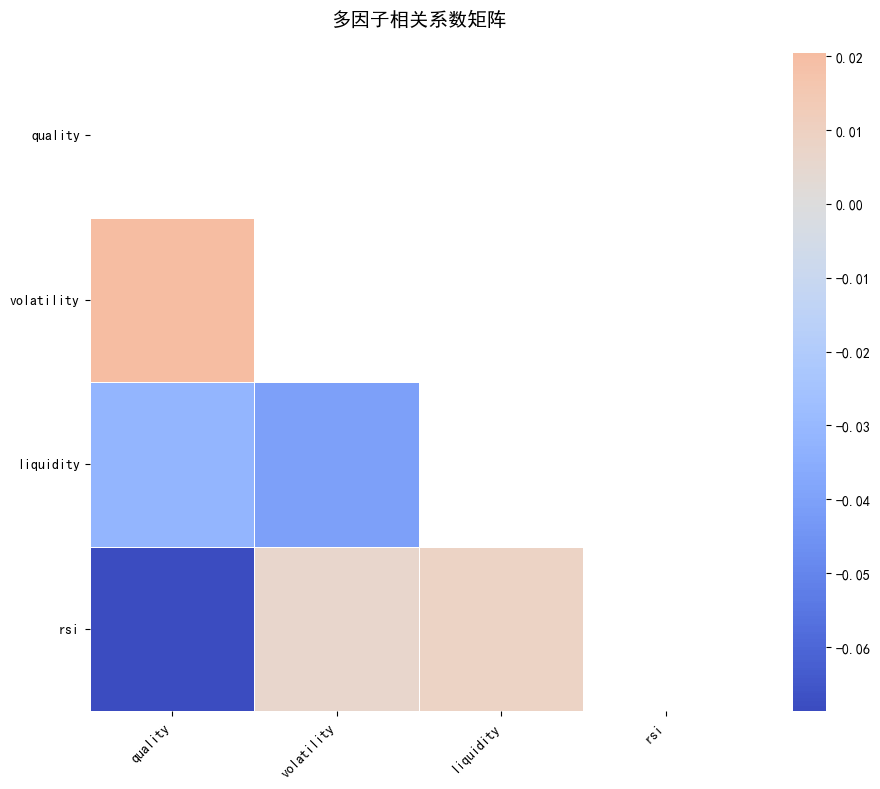


分析完成! 结束时间: 2025-05-13 11:14:12


In [7]:
# -------------------- 主流程 --------------------
if __name__ == "__main__":
    print("===沪深300多因子分析系统 ===")
    print("开始时间:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    rf_rate = get_bond_yield().mean()
    
    print("\n1. 获取沪深300全部成分股...")
    symbols = get_hs300_symbols()
    print(f"共获取到{len(symbols)}支成分股")
    
    print("\n2. 并行下载股票数据...")
    dfs = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(get_stock_data, sym): sym for sym in symbols}
        for future in as_completed(futures, timeout=120):
            try:
                result = future.result()
                if not result.empty:
                    dfs.append(result)
                    if len(dfs) % 50 == 0:
                        print(f"已下载{len(dfs)}支股票数据...")
            except Exception as e:
                print(f"下载{futures[future]}失败: {e}")
    
    if not dfs:
        raise ValueError("没有获取到有效股票数据")
    
    print("\n3. 数据预处理...")
    full_data = pd.concat(dfs)
    close = full_data.pivot_table(index='日期', columns='symbol', values='收盘').ffill().dropna(axis=1)
    volume = full_data.pivot_table(index='日期', columns='symbol', values='成交量')[close.columns]
    
    print("\n4. 计算因子...")
    start_time = time.time()
    
    # 计算四个因子
    quality_factors = calculate_quality_factors(close, volume)
    realized_vol_factors = calculate_realized_volatility(close)
    liquidity_factors = calculate_liquidity_factor(close, volume)
    rsi_factors = calculate_rsi(close)
    
    # 动态对齐因子数据
    factors_dict = align_factors(quality_factors, realized_vol_factors, liquidity_factors, rsi_factors)
    factors_dict = {
        'quality': factors_dict['factor_1'],
        'volatility': factors_dict['factor_2'],
        'liquidity': factors_dict['factor_3'],
        'rsi': factors_dict['factor_4']
    }
    
    avg_sharpe, corrected_factors = calculate_average_sharpe(factors_dict, close, rf_rate)
    
    normalized_factors = pd.DataFrame(index=list(corrected_factors.values())[0].index)
    for name, factor in corrected_factors.items():
        normalized_factors[name] = factor.mean(axis=1)
    
    print(f"\n因子计算完成，总耗时{time.time()-start_time:.2f}秒")
    print(f"有效数据天数: {len(normalized_factors)}")
    print(f"有效股票数量: {len(close.columns)}")
    
    plot_correlation_heatmap(normalized_factors)
    
    print("\n分析完成! 结束时间:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))